### Project Description

One of the goals in this project is to analyze the energetics of M31 and MW before merger, as well as the energetic of the merger remnant. This is motivated by the preliminary discovery that M31 contributes more to the dark matter in the inner regions of the merged halo, while MW contributes more to the outer region, despite both starting with the same profile. To achieve my goal, I've created a HaloEnergetics class that handles all the methods relevant to the study.

In [1]:
# import modules
from os.path import join
import numpy as np
import astropy.units as u
from astropy.constants import G
import scipy.optimize as so
from colossus.cosmology import cosmology
from IPython.display import Latex

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from HaloEnergetics import HaloEnergetics, MergedHaloEnergetics
from MassProfile import MergedMassProfile

When provided with an array of radii, the HaloEnergetics object will automatically calculate the following class variables, using the input radii as bin edges:

*  `self.r`: array of radii that corresponds to the density profile and potential energy, in $kpc$.
*  `self.rho`: density profile, in $M_{\odot}~kpc^{-3}$
*  `self.a`: scale length as defined in the Hernquist density profile (Hernquist 1990)
*  `self.r_vir`: virial radius of the halo, defined as 200 times the critical density of the universe.
*  `self.U`: array of self gravitational potential energy corresponding to `self.r`
*  `self.U_tot`: total self gravitational potential energy, defined as potential energy within `self.r_vir`
*  `self.K`: array of internal kinetic energy relative to the center of mass
*  `self.K_tot`: total kinetic energy, defined as potential energy within `self.r_vir`

The equation I'm using for the density profile given the enclose mass profile is:

$$\rho_i = \frac{M_{enc, i+1} - M_{enc, i}}{V_{enc, i+1} - V_{enc, i}}$$

where $\rho$ are the densities, $M_{enc}$ are enclosed masses, $V_{enc}$ are the enclosed volumes. The radii for $\rho_i$ is:

$$r_i = \frac{R_{i+1} + R_i}{2},$$

where $R$ are the radii for the enclosed mass profile.

The equation for the self gravitational potential energy enclosed within $r$ is:

$$U = -\frac{GM^2}{6a} + \frac{GM^2a}{2(r+a)^2} - \frac{GM^2a^2}{3(r+a)^3},$$

and the enclosed kinetic energy is computed by summing the kinetic energies of enclosed particles relative to the center of mass.

In [2]:
# Define an array of radii to initialize the HaloEnergetics object
# note that this is not the same array that will correspond to the density profile
r_enc = np.logspace(0.7, 3, 47)

In [3]:
# Initialize Halo objects for MW and M31 before and after merger
MW_0 = HaloEnergetics('MW', 0, r_enc)
M31_0 = HaloEnergetics('M31', 0, r_enc)
MW_800 = HaloEnergetics('MW', 800, r_enc)
M31_800 = HaloEnergetics('M31', 800, r_enc)

In [4]:
Merged = MergedHaloEnergetics(800, r_enc)

In [5]:
Merged.read_from_components(MW_800, M31_800)
Merged.hernquist_pot_energy_components()

In [6]:
r = MW_0.r

In [7]:
# Fractional density differences between MW and M31
f_0 = (M31_0.rho - MW_0.rho) / MW_0.rho
f_800 = (M31_800.rho - MW_800.rho) / MW_800.rho

In [8]:
# Total energies for all systems
E_MW_0 = MW_0.U+MW_0.K
E_M31_0 = M31_0.U+M31_0.K
E_MW_800 = Merged.U_MW+MW_800.K
E_M31_800 = Merged.U_MW+M31_800.K

In [9]:
# Fractional energy differences for all systems
f_E_MW_M31_0 = (E_M31_0-E_MW_0) / E_M31_0
f_U_MW_M31_0 = (M31_0.U-MW_0.U) / M31_0.U
f_K_MW_M31_0 = (M31_0.K-MW_0.K) / M31_0.K

All the basic computations are done here. Below are mostly code for plots. They're not in any specific order, but the contents of the plots are commented at the top of each cell.

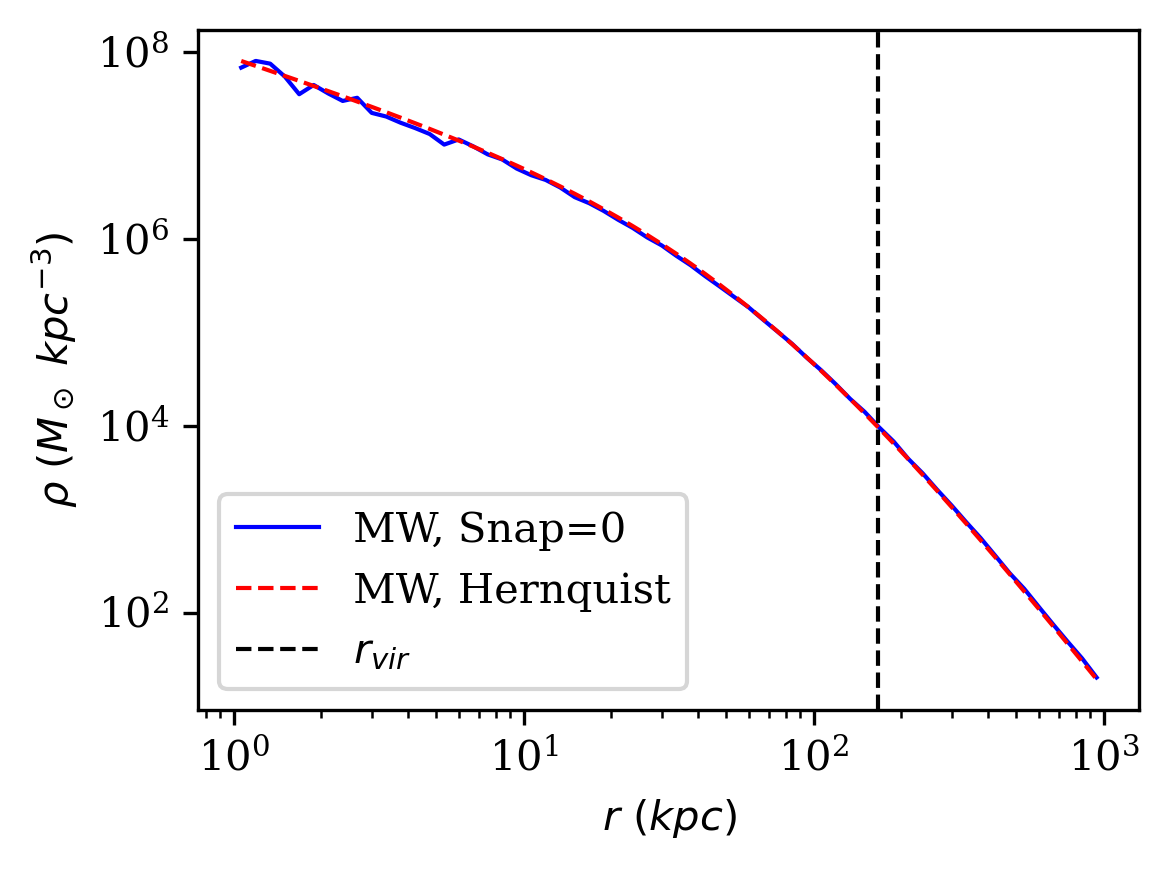

In [5]:
# Plot density profile of MW and hernquist fit
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.loglog(r, MW_0.rho, color='blue', lw=1, label='MW, Snap=0')
plt.loglog(r, MW_0.hernquist(MW_0.r, MW_0.M, MW_0.a), color='red', linestyle='--', lw=1, label='MW, Hernquist')
plt.axvline(MW_0.r_vir, color='k', lw=1, linestyle='--', label=r'$r_{vir}$')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\rho$ $(M_\odot~kpc^{-3})$')
plt.legend()
plt.tight_layout()
plt.savefig('figs/MW_0_rho_fit.jpg')
plt.show()

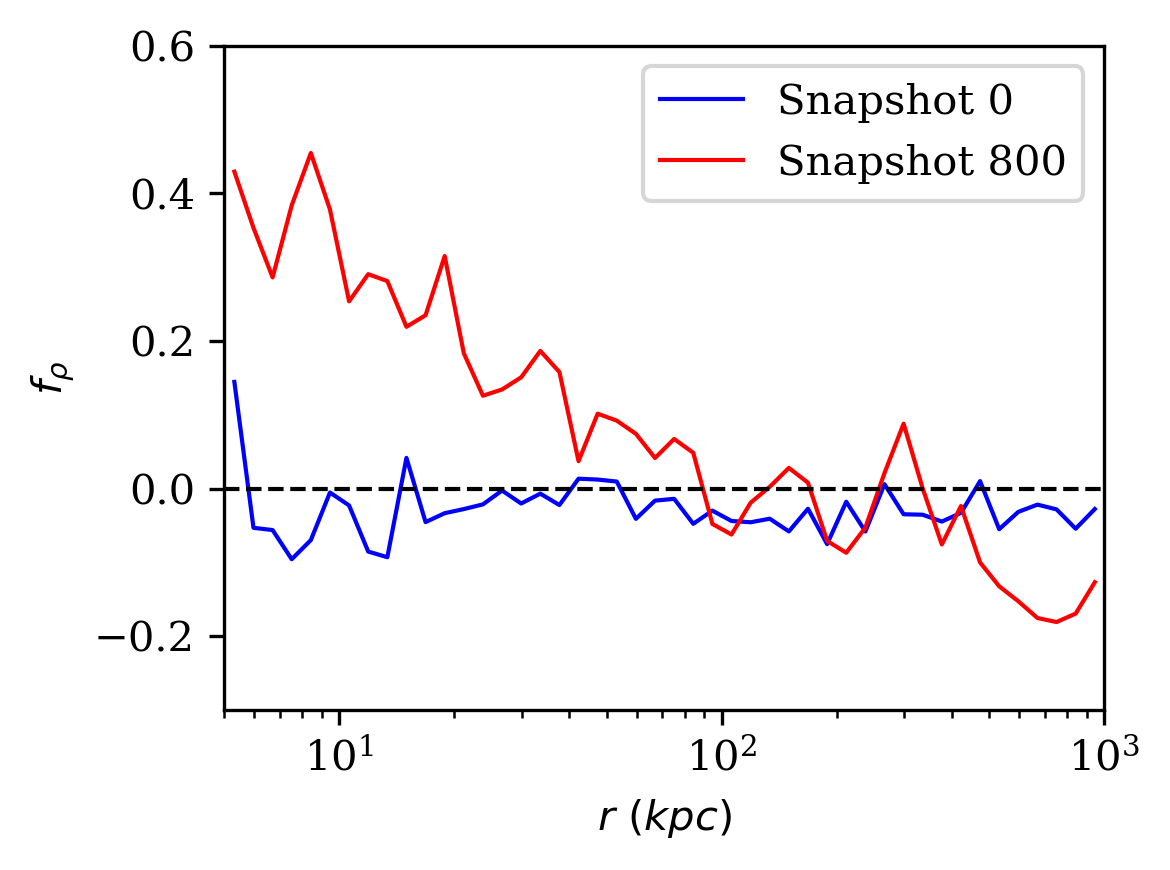

In [12]:
# Compare density difference for snapshot 0 and 800
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.plot(r, f_0, color='blue', lw=1, label='Snapshot 0')
plt.plot(r, f_800, color='red', lw=1, label='Snapshot 800')
plt.axhline(0, ls='--', lw=1, color='black')
plt.xscale('log')
plt.xlim(5, 1000)
plt.ylim(-0.3, 0.6)
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$f_\rho$')
plt.legend()
plt.tight_layout()
plt.savefig('figs/f_M31_MW_comp.jpg')
plt.show()

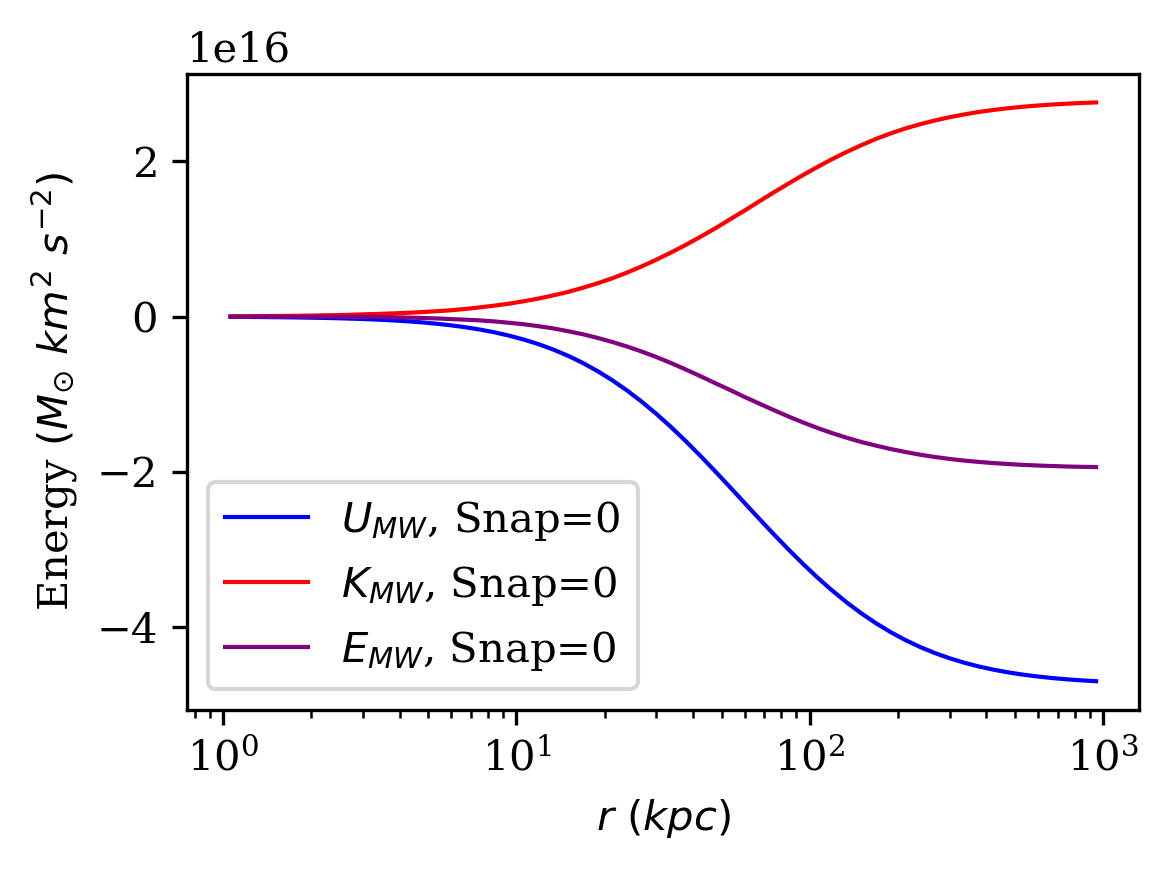

In [26]:
# Plot MW energy profile
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.semilogx(r, -MW_0.U, color='blue', lw=1, label=r'$U_{MW}$, Snap=0')
plt.semilogx(r, MW_0.K, color='red', lw=1, label=r'$K_{MW}$, Snap=0')
plt.semilogx(r, -MW_0.U+MW_0.K, color='purple', lw=1, label=r'$E_{MW}$, Snap=0')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'Energy $(M_{\odot}~km^2~s^{-2})$')
plt.legend()
plt.tight_layout()
plt.savefig('figs/E_MW_0.jpg')
plt.show()

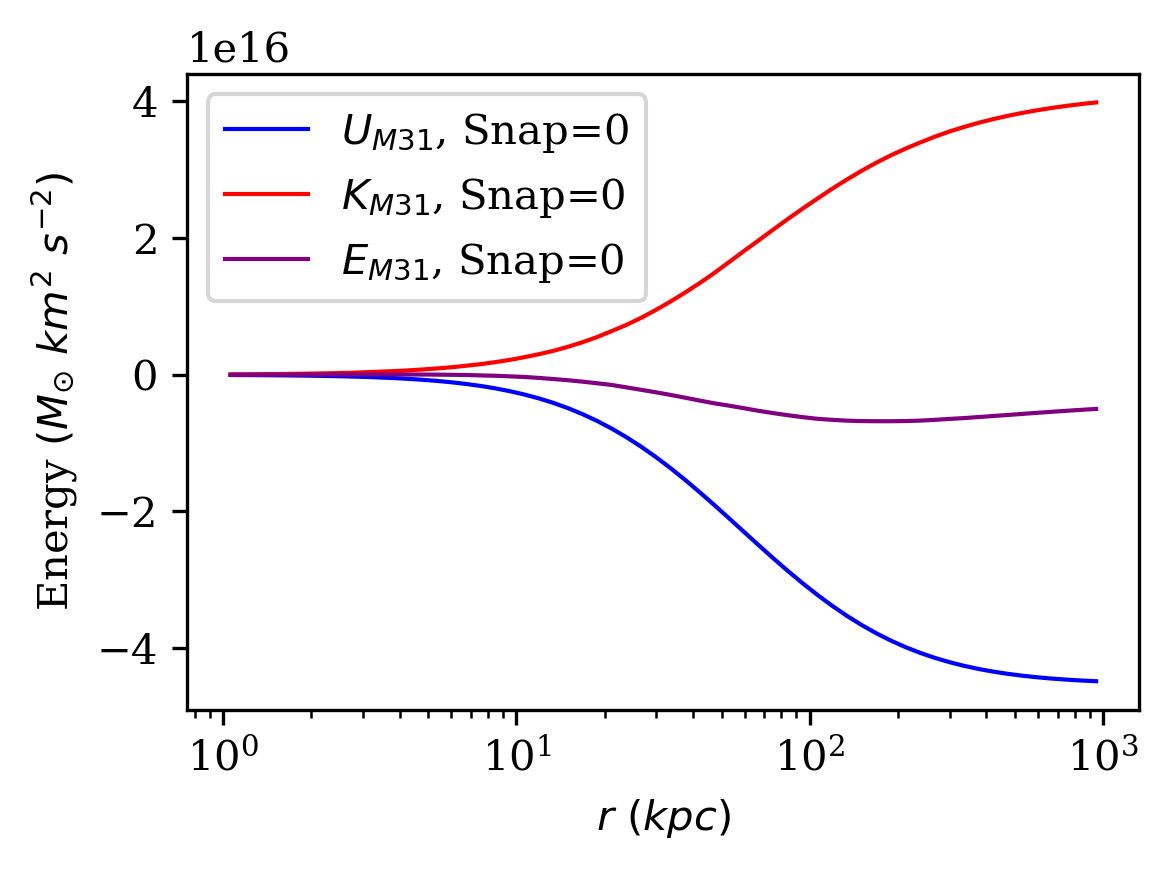

In [27]:
# Plot M31 energy profile
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.semilogx(r, -M31_0.U, color='blue', lw=1, label=r'$U_{M31}$, Snap=0')
plt.semilogx(r, M31_0.K, color='red', lw=1, label=r'$K_{M31}$, Snap=0')
plt.semilogx(r, -M31_0.U+M31_0.K, color='purple', lw=1, label=r'$E_{M31}$, Snap=0')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'Energy $(M_{\odot}~km^2~s^{-2})$')
plt.legend()
plt.tight_layout()
plt.savefig('figs/E_M31_0.jpg')
plt.show()

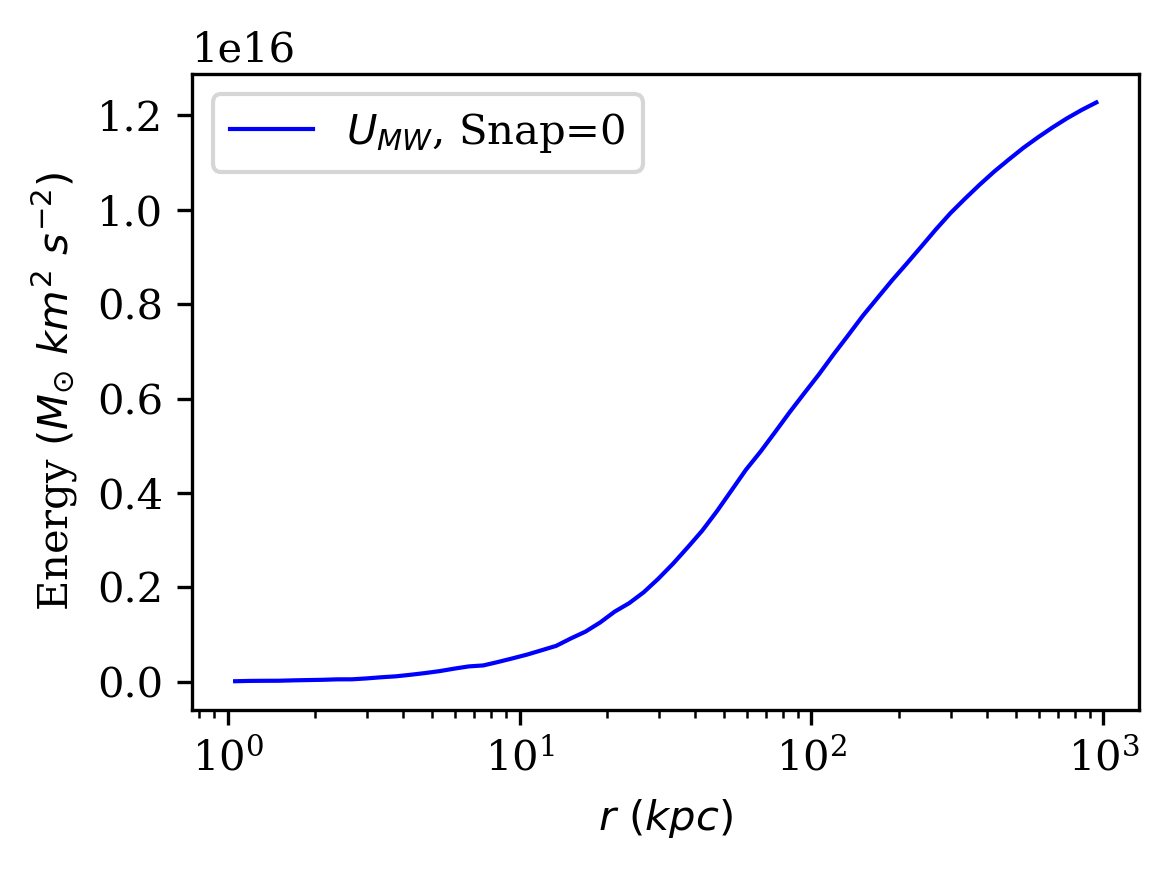

In [28]:
# Plot MW energy profile
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.semilogx(r, M31_0.K-MW_0.K, color='blue', lw=1, label=r'$U_{MW}$, Snap=0')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'Energy $(M_{\odot}~km^2~s^{-2})$')
plt.legend()
plt.tight_layout()
#plt.savefig('figs/E_MW_0.jpg')
plt.show()

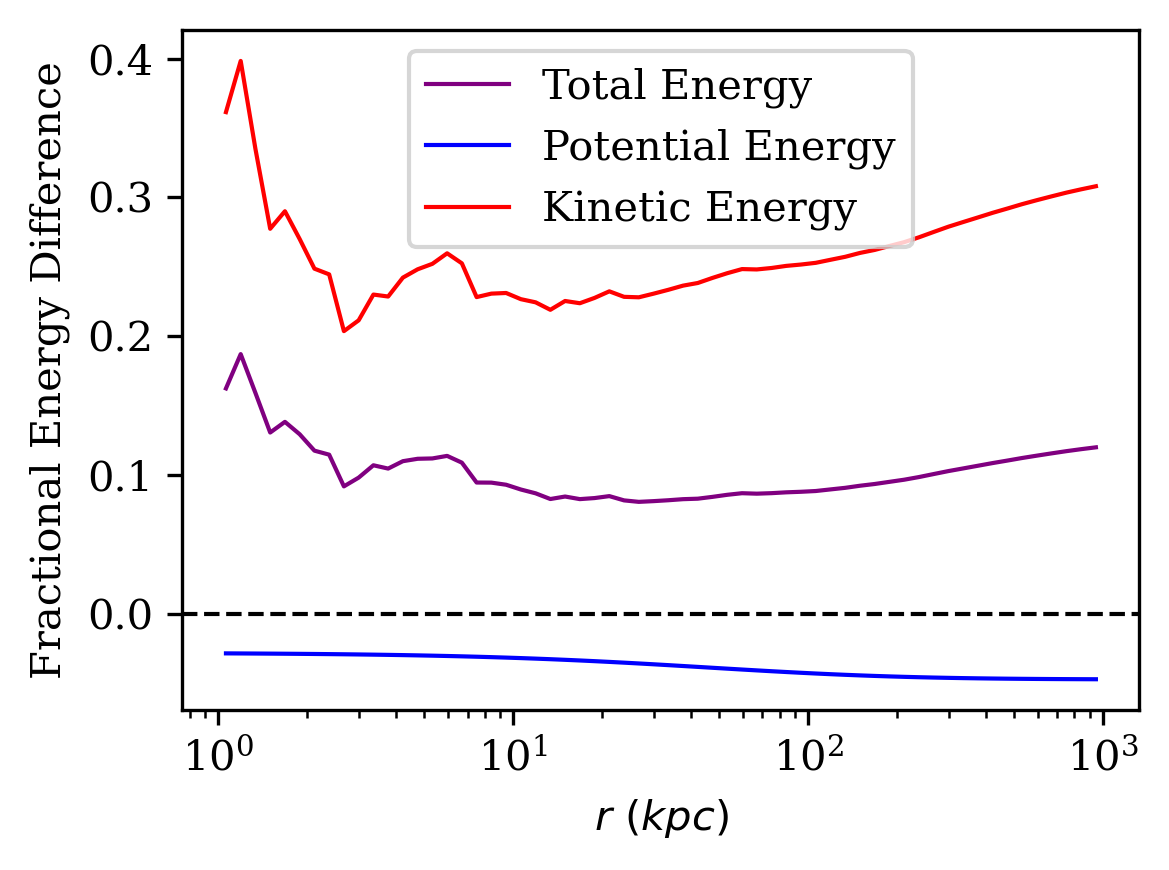

In [14]:
# Compare total internal energy profile of MW and M31
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.semilogx(r, f_E_MW_M31_0, color='purple', lw=1, label='Total Energy')
plt.semilogx(r, f_U_MW_M31_0, color='blue', lw=1, label='Potential Energy')
plt.semilogx(r, f_K_MW_M31_0, color='red', lw=1, label='Kinetic Energy')
plt.axhline(0, ls='--', lw=1, color='black')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'Fractional Energy Difference')
plt.legend()
plt.tight_layout()
plt.savefig('figs/f_E_MW_M31_0.jpg')
plt.show()

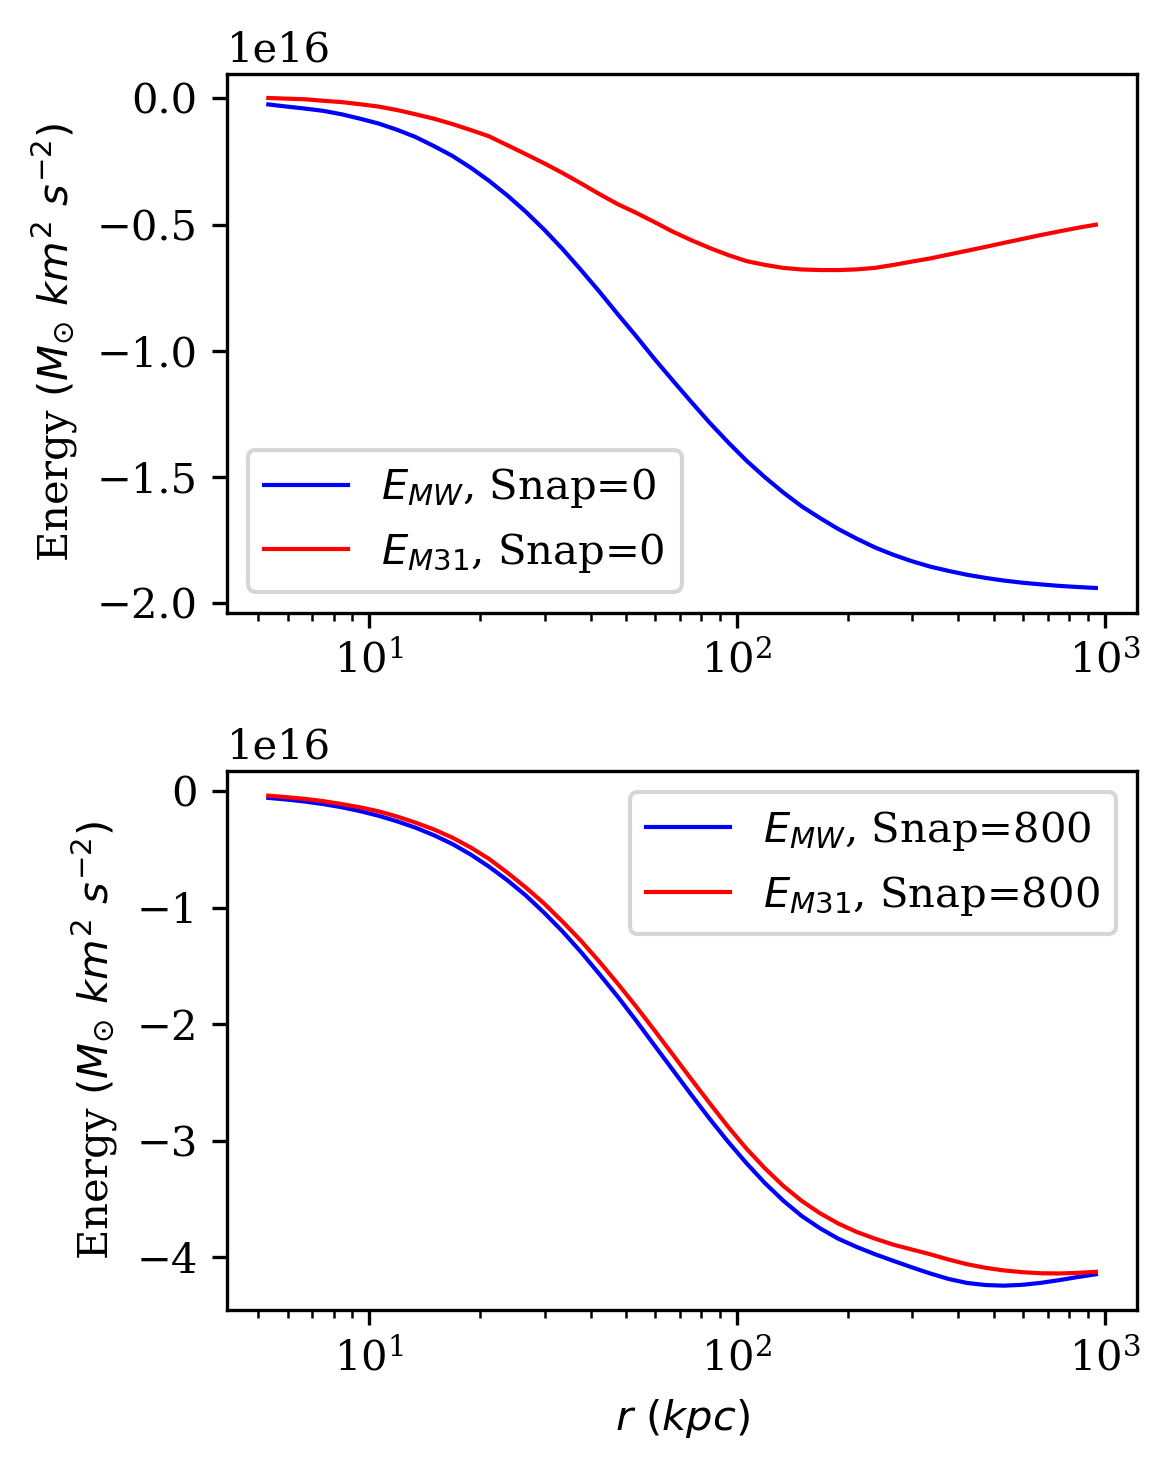

In [13]:
# Compare total internal energy profile of MW and M31
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
fig, axs = plt.subplots(2, 1, figsize=(4, 5))
axs[0].semilogx(r, E_MW_0, color='blue', lw=1, label=r'$E_{MW}$, Snap=0')
axs[0].semilogx(r, E_M31_0, color='red', lw=1, label=r'$E_{M31}$, Snap=0')
axs[1].semilogx(r, E_MW_800, color='blue', lw=1, label=r'$E_{MW}$, Snap=800')
axs[1].semilogx(r, E_M31_800, color='red', lw=1, label=r'$E_{M31}$, Snap=800')
axs[1].set_xlabel(r'$r$ $(kpc)$')
axs[0].set_ylabel(r'Energy $(M_{\odot}~km^2~s^{-2})$')
axs[1].set_ylabel(r'Energy $(M_{\odot}~km^2~s^{-2})$')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.savefig('figs/E_MW_M31_comparison.jpg')
plt.show()

In [9]:
f_E_MW_M31_800 = (E_M31_800-E_MW_800) / E_M31_800
f_U_MW_M31_800 = (M31_800.U-MW_800.U) / M31_800.U
f_K_MW_M31_800 = (M31_800.K-MW_800.K) / M31_800.K

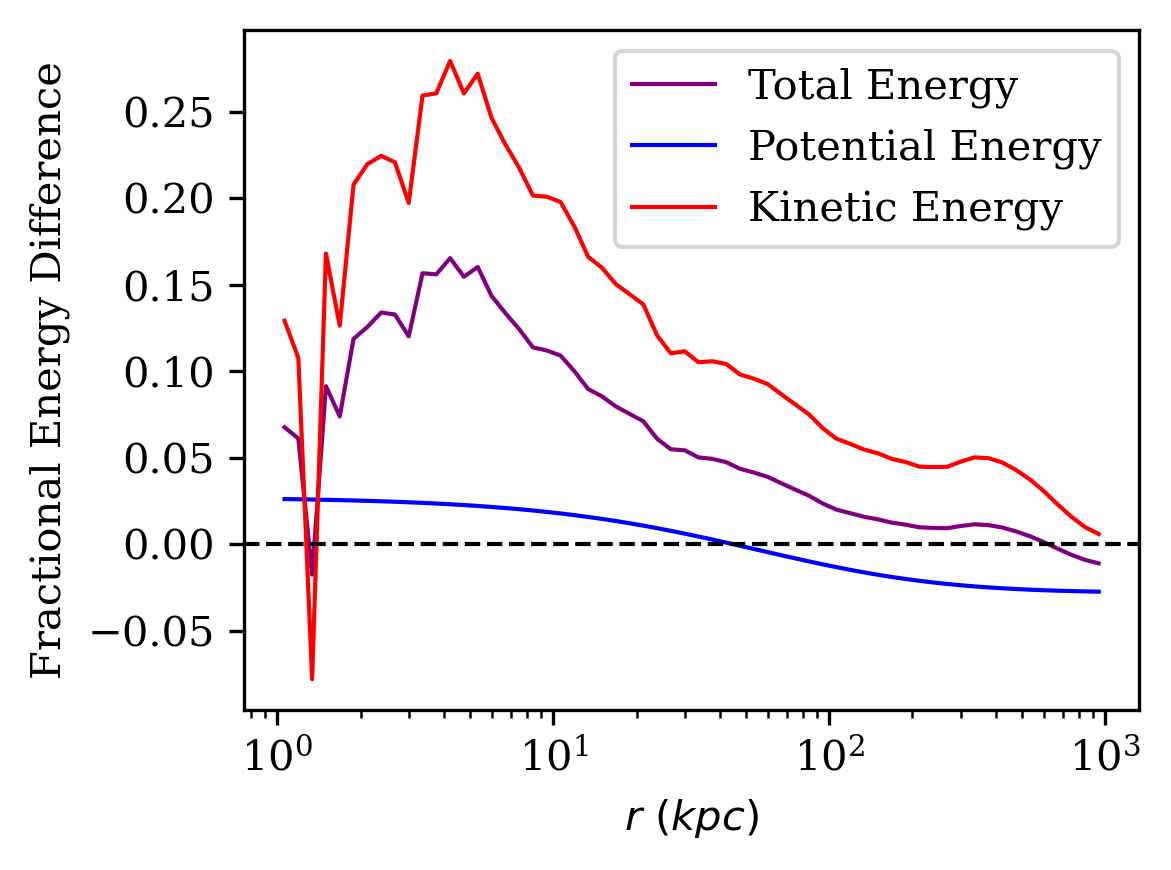

In [10]:
# Compare total internal energy profile of MW and M31
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.semilogx(r, f_E_MW_M31_800, color='purple', lw=1, label='Total Energy')
plt.semilogx(r, f_U_MW_M31_800, color='blue', lw=1, label='Potential Energy')
plt.semilogx(r, f_K_MW_M31_800, color='red', lw=1, label='Kinetic Energy')
plt.axhline(0, ls='--', lw=1, color='black')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'Fractional Energy Difference')
plt.legend()
plt.tight_layout()
plt.savefig('figs/f_E_MW_M31_800.jpg')
plt.show()

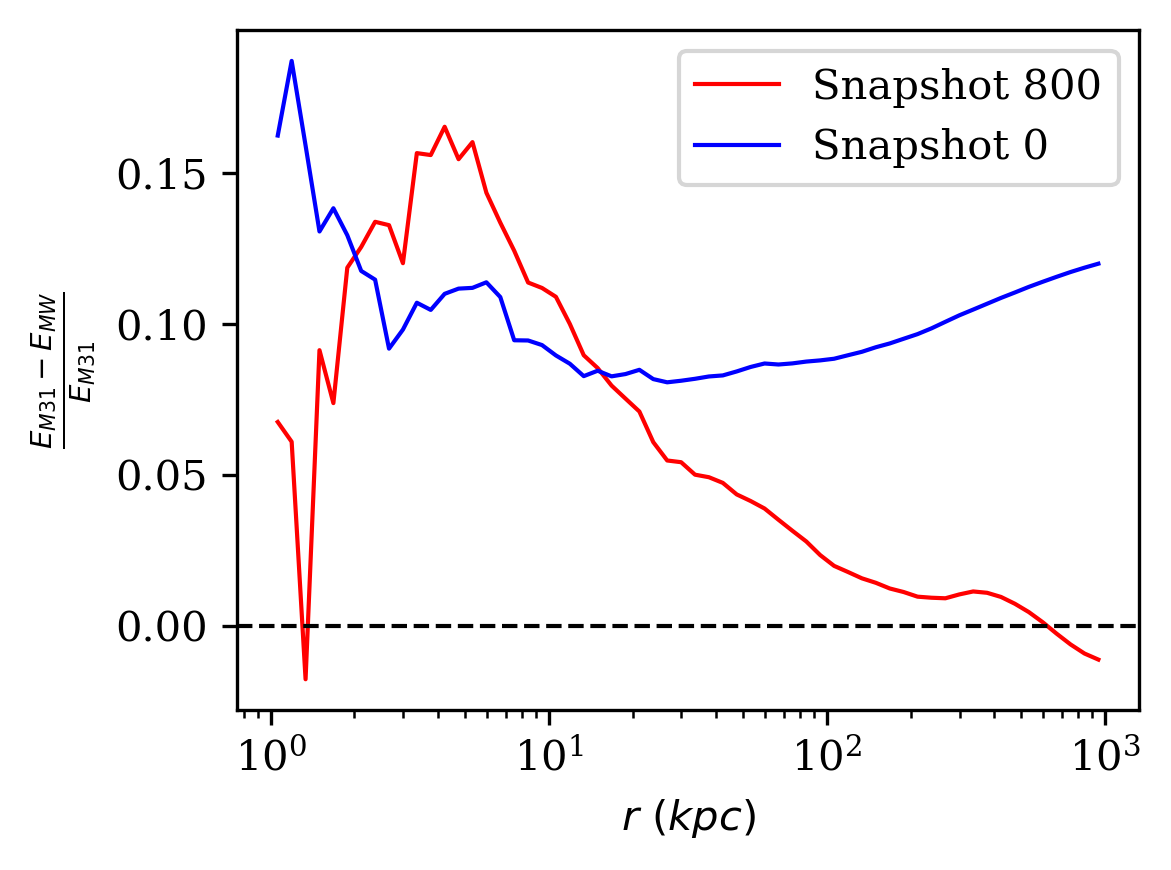

In [13]:
# Compare how energy difference between MW and M31 particles changed after merger
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.semilogx(r, f_E_MW_M31_800, color='red', lw=1, label='Snapshot 800')
plt.semilogx(r, f_E_MW_M31_0, color='blue', lw=1, label='Snapshot 0')
plt.axhline(0, ls='--', lw=1, color='black')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\frac{E_{M31}-E_{MW}}{E_{M31}}$')
plt.legend()
plt.tight_layout()
plt.savefig('figs/f_E_comparison.jpg')
plt.show()

In [17]:
dE_MW = (E_MW_800-E_MW_0)
dE_M31 = (E_M31_800-E_M31_0)

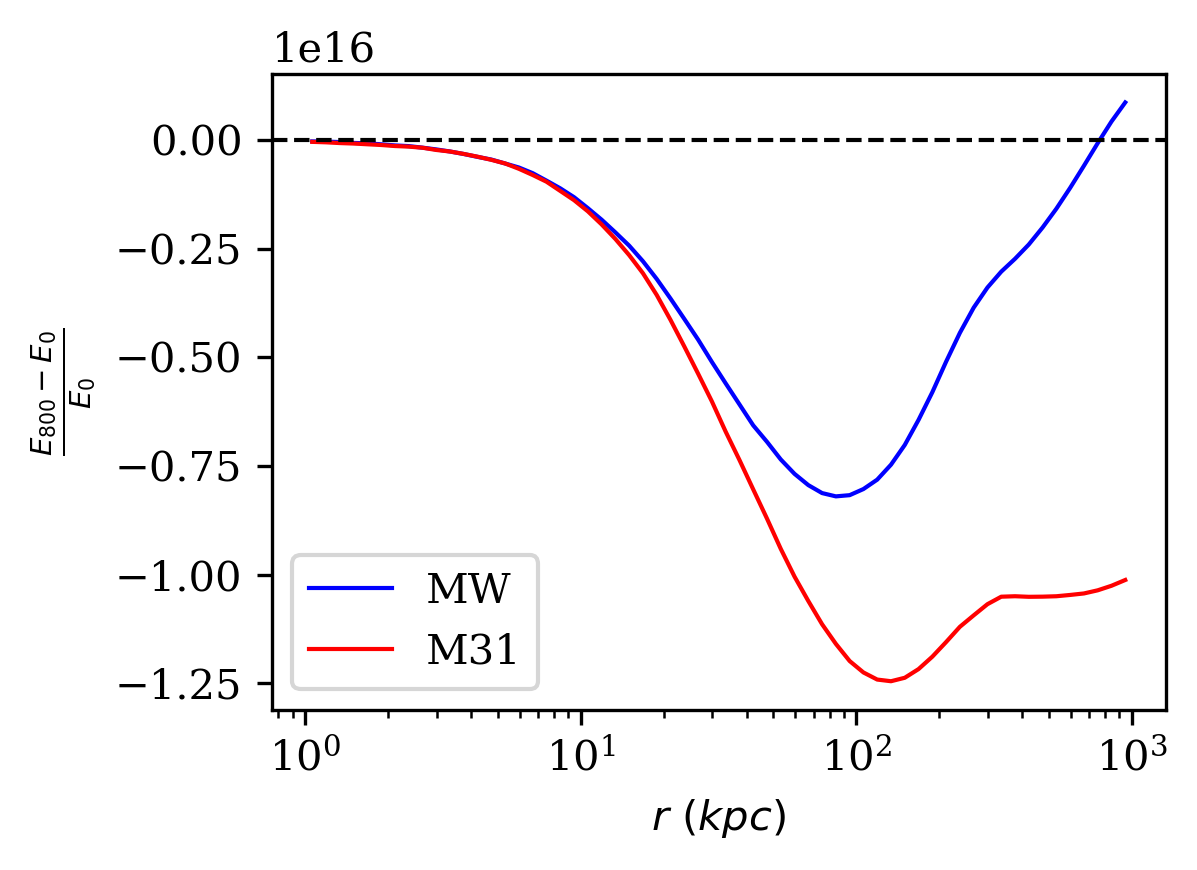

In [18]:
# Compare how energy distribution changed over merger for each halo
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(4, 3))
plt.semilogx(r, dE_MW, color='blue', lw=1, label='MW')
plt.semilogx(r, dE_M31, color='red', lw=1, label='M31')
plt.axhline(0, ls='--', lw=1, color='black')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\frac{E_{800}-E_{0}}{E_{0}}$')
plt.legend()
plt.tight_layout()
plt.savefig('figs/dE_comparison.jpg')
plt.show()